# Falcons.jl

[Falcons](https://yusuke-takase.github.io/Falcons.jl/dev/)は宇宙マイクロ波背景放射(Cosmic Microwave Background, CMB)など衛星による全天観測が求められる実験のためのシミュレーションツールである．

一般に，観測衛星は望遠鏡を空のある一点へ向け，その点からの放射を観測する．この時，望遠鏡が向いている方向を特徴づける量として Pointing という量が用いられ，次の形で定義される．

$$
\boldsymbol{p(t)} = ( \theta(t), \phi(t), \psi(t) )
$$

ここで$\theta, \phi$は 3 次元極座標の定義と一致する．また，$\psi$は軌跡の接線が空の経線となす角と定義される．
つまり，$p(t)$はある時刻$t$において衛星の望遠鏡/アンテナが，空の$(\theta, \phi)$を角度$\psi$でスキャンしたことを記述し，特に$\psi$は検出器の偏光観測角度にも対応するため偏光観測に重要なパラメータとなる．

以下に NASA から引用した[COSMO conventions](https://lambda.gsfc.nasa.gov/product/about/pol_convention.cfm)を載せておく．
<img src="./img/healpix_cosmo.png">


## HEALPix

<img src="./img/healpixGridRefinement.jpg">

[HEALPix](https://healpix.jpl.nasa.gov/)は球面上のデータをピクセルという領域に区切って扱うためのフレームワークで，C++や Python ([healpy](https://healpy.readthedocs.io/en/latest/))などの様々な言語でサポートされている．
`Falcons.jl`は[Healpix.jl](https://github.com/ziotom78/Healpix.jl)に依存している．ここでは簡単に`Healpix.jl`を用いて`HEALPix`のピクセルという概念を確認する．


In [1]:
using Healpix
using Plots
#using PyPlot
#pyplot()

HEALPix は$Nside$というパラメータを指定することで空を$Npix$個のピクセルに分割する．$Nside$と$Npix$の関係は次のようになる．

$$
Npix = 12Nside^2
$$

ここで$Nside$は$2$の累乗である必要がある．  
次に`HEALPix`のスカイマップの仕組みについて確認する．マップは$Npix$個の要素を持つ配列から作られ，北極から南極にかけて螺旋状にインデックスが与えられる`Ring Order`がよく用いられる．
ピクセルのインデックスは以下の図で確認できる．

<img src="./img/pixel_grid.png">

[The HEALPix Primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf)より引用．

上の図を実際に再現してみると次のようになる．


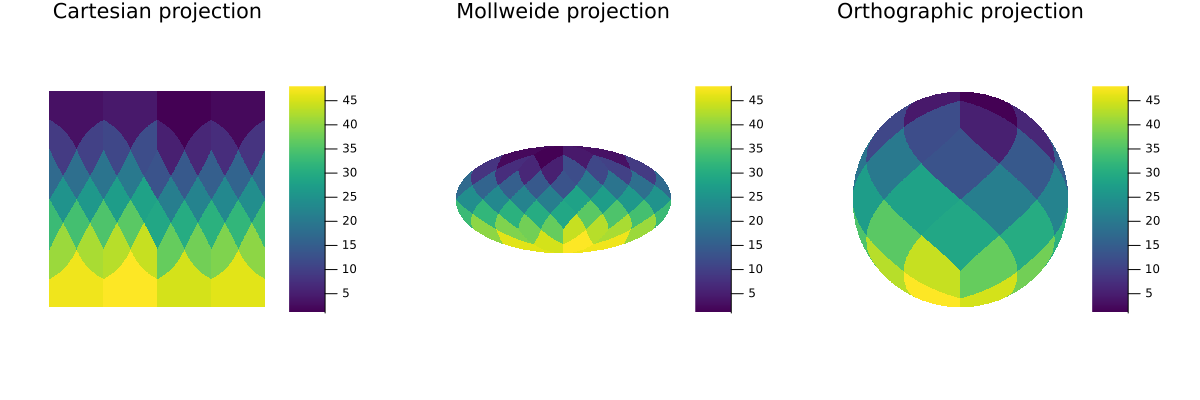

In [2]:
nside = 2
m = HealpixMap{Float64, RingOrder}(nside)
m.pixels = 1:length(m)

cartview = Plots.plot(m, equirectangular, c=:viridis, title="Cartesian projection")
mollview = Plots.plot(m, mollweide, c=:viridis, title="Mollweide projection")
orthoview = Plots.plot(m, orthographic, c=:viridis, title="Orthographic projection")

Plots.plot(cartview, mollview, orthoview , layout=(1,3), size=(1200,400))

`Healpix.jl`は`HealpixMap`という構造体を Plots へ渡すことで，球面を様々形状の 2D マップへ投影する機能も提供している．

## API example

`HEALPix`は$(x,y,z)$や$(\theta,\phi)$からピクセルを指定したり，その逆を行なうための API を提供している．
試しに$(\pi/3, \pi/2)$の位置に$200$という値を代入してプロットしてみる．


pix = ang2pixRing(res, π / 3, π / 2) = 45


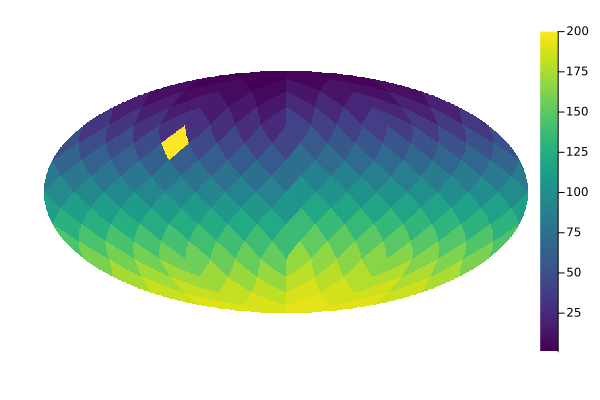

In [3]:
nside = 4
res = Resolution(nside)
@show pix = ang2pixRing(res, π/3, π/2)
m = HealpixMap{Float64, RingOrder}(nside)
m.pixels = 1:length(m)
m.pixels[pix] = 200
Plots.plot(m, c=:viridis, size=(600,400))

Nside を大きくしたため，マップの解像度が上がっていることがわかる．  
黄色く変わったピクセルが$(\theta, \phi)=(\pi/3, \pi/2)$に位置するピクセルであり，HEALPix のピクセルインデックスでは 45 番目のピクセルに位置している．


# 衛星スキャン戦略

全天観測衛星は宇宙全天を隈なく探索するためのスキャン戦略を設定する．スキャン戦略の代表的なパラメータは以下の 4 つで，

$$
\alpha: 歳差軸角度 \\
\beta: スピン軸角度 \\
\omega_\alpha: 歳差角速度 \\
\omega_\beta: スピン角速度
$$

歳差運動とスピンによる回転で衛星の観測方向を回転させながらスキャンを行う．この時，太陽-地球系の L2 点に設置される衛星では公転運動も利用する場合が多い．
<img src="./img/scan_strategy.png">


# Falcons のデモンストレーション

ここから`Falcons`のデモンストレーションを行う．初めにスキャン戦略を設定する．


In [4]:
using Falcons

ss = gen_ScanningStrategy();
ss.nside = 64
ss.alpha = 40
ss.beta = 55
ss.spin_rpm = 0.03
ss.prec_rpm = period2rpm(160) # period2rpm( min. )
ss.sampling_rate = 1;

`ss`は`ScanningStrategy`という構造体になっており，上記のようにアクセスできる．

設定したスキャン戦略で空がどのようにスキャンされるかプロットして確認する．  
Pointing の時系列データ(Time-Orderd Data, TOD)を取得するには`get_pointings`関数を使用する．この際，引数は`ss`と観測期間のみで良い．


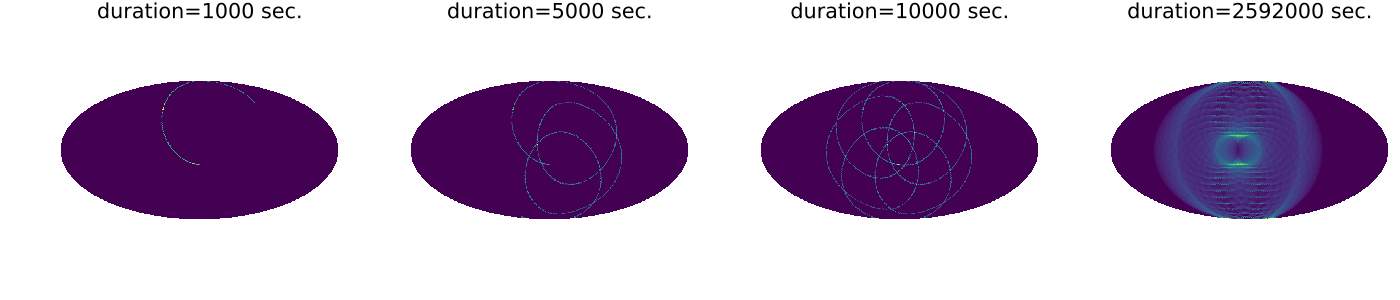

In [5]:
day = 60*60*24
time = [1000, 5000, 10000, 30day]
track = [HealpixMap{Float64, RingOrder}(ss.nside) for i in eachindex(time)]

for i in eachindex(time)
    # pointingの計算
    pointings = get_pointings(ss, 0, time[i]) # 観測期間を0秒からtime[i]までとして設定
    # TOD --> Mapへ格納
    track[i].pixels = angtod2hitmap(
        ss.nside, 
        pointings[1], # theta 
        pointings[2], # phi
    )
end

plts = [Plots.plot(track[i], c=:viridis, title="duration="*"$(time[i]) sec.", cbar=nothing) for i in eachindex(time)]
Plots.plot(plts[1], plts[2], plts[3], plts[4], layout=(1,length(time)), size=(1400,300))

`get_pointings`関数の返り値は辞書型の配列になっており，それぞれ

```julia
pointings = get_pointings(ss::ScanningStrategy, start::Int, stop::Int)

theta = pointings[1]
phi = pointings[2]
psi = pointings[3]
time = pointings[4]
```

という構造を持つ．これらの配列要素には TOD が格納されている．  
また，Hitmap を作成するためには`angtod2hitmap`関数を使用すれば良い．引数は Nside と$\theta, \phi$の TOD である。


ここでクロスリンクという新たな概念を導入する．近年，CMB の偏光を精密測定することでインフレーション起源の原始重力波を探索する研究が世界中で行われている．
一般に，偏光を観測するためには検出器の角度$\psi$を変えながら複数回観測する必要がある．つまり，全天に分布するピクセルから放射される電磁波の偏光を衛星で測定するためには，衛星はそのピクセルをあらゆる方向からスキャンしなければならない．

このピクセルが複数回のヒット(測定)の中で，どのような方向でスキャンされたかを知るための量がクロスリンク$X_n$であり[(arXiv:1604.02290: Christopher G. R. Wallis et al.)](https://arxiv.org/abs/1604.02290)，空の全てのピクセルについて次の式で表される．

$$
X_n = \left[ \left(\frac{\sum^{N_{hits}}_i{\sin{(n\psi_i)}}}{N_{hits}} \right)^2 + \left( \frac{\sum^{N_{hits}}_i{\cos{(n\psi_i)}}}{N_{hits}}\right)^2 \right]
    = \langle \sin(n\psi_i) \rangle^2 + \langle \cos(n\psi_i) \rangle^2
$$

$\psi_i$はピクセルのスキャン角度(=検出器の角度)であり，添字$i$は$i$番目の測定を表す．もし同じ方向しかスキャンが行われず，$\psi_i$の分布に偏りがあればクロスリンク$X_n$は大きくなり，逆に満遍なく様々な角度でスキャンされたピクセルでは$X_n$が小さくなる．また式より$0\leq X_n \leq1$であることもわかる．

ここで，偏光観測において検出器の角度$\psi$が 180 度回転しても結果が変わらないことから$\psi$は$2\psi$と表記される．
このことから特に，$n=2$のクロスリンクは，偏光観測の不定性の１つの指標と見なすことができる．


In [6]:
spin_n = [0,1,2]
spin_m = [0,4,8]
ss.duration = 365day
field = get_scanfield(ss, division=12, spin_n=spin_n, spin_m=spin_m);
xlink = HealpixMap{Float64, RingOrder}(ss.nside)
xlink .= abs.(h_nm(field, 2,0)); # spin_n=2, spin_m=0のcross-linkの絶対値を計算

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


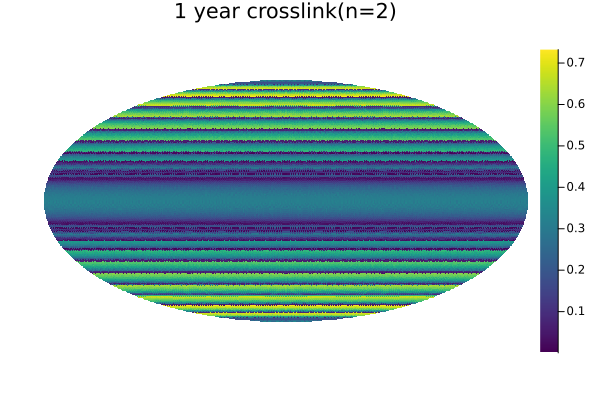

In [7]:
Plots.plot(xlink, c=:viridis, title="1 year crosslink(n=2)")

# スキャン戦略の吟味

上では`ScanningStrategy2map`でスキャン戦略設定から Hitmap とクロスリンクまで一度に計算が可能であることを確かめた．次に実際に観測を行うことを想定して適切なスキャン戦略について考えてみる．

上の Hitmap/クロスリンクマップでは$\phi$方向(東西方向)に線が走っていることが見て取れる．これは軌道が重なる点が公転運動でそのままシフトしていくことが原因である．(１ヶ月の Hitmap を参照)
これでは全天スキャンの結果に偏りが生じてしまい，系統誤差を生んでしまう可能性がある．

マップの分布をヒストグラムで確認してみる．ヒストグラムの分散が小さい方がスキャンが均一であると言える．


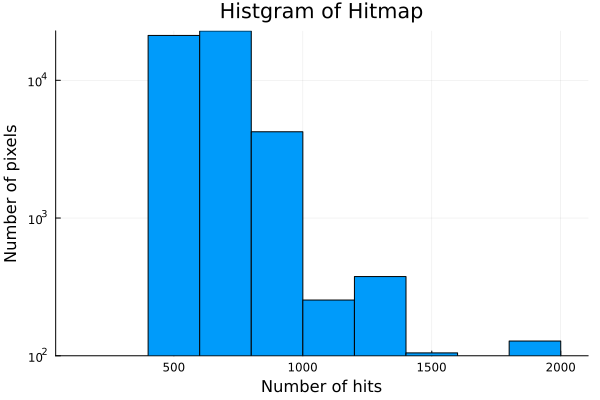

In [8]:
histogram(field.hitmap, bins=range(0, maximum(field.hitmap), step=200),
    title="Histgram of Hitmap",
    xlabel="Number of hits",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis=:log10)

ヒストグラムが分裂しているため，ヒットに偏りがあることがわかる．またヒストグラム幅も 500 - 2000 ヒットにわたって分布している．  
クロスリンク(n=2)についても確認してみる．


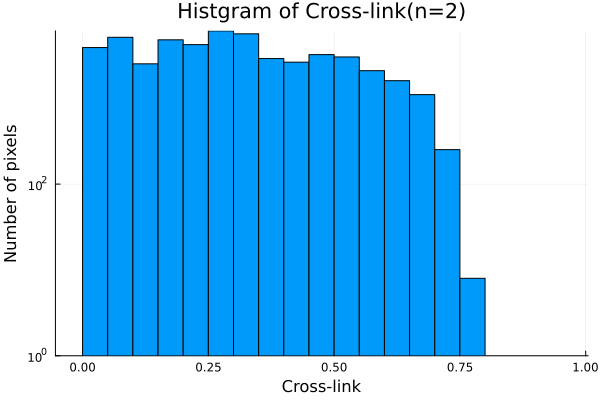

In [9]:
histogram(xlink.pixels, bins=range(0, 1, step=0.05),
    title="Histgram of Cross-link(n=2)",
    xlabel="Cross-link",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis =:log10)

クロスリンクも分散が大きく，平均値も大きいことがわかる．すなわちこのスキャン戦略はあまり偏光観測には適していないということになる．


# スキャン戦略の再構築

では偏光観測に適しているスキャン戦略はどのようになるだろうか？
例えば，衛星の角速度について[Duc Thuong Hoang et al.](https://arxiv.org/abs/1706.09486)によると
$\theta=\frac{\omega_{spin}}{\omega_{prec}}$，$a_n$を整数と定義した時，

<img src="./img/ratio.png">

のような表式で展開できる$\theta$の場合，軌道がだんだんずれていき，同じ緯度上で重なりにくくなるようである．  
この論文に倣って，スピンと歳差運動の角速度比が割り切れない数値でスキャン戦略の再構成を行う．


In [10]:
println("スピンの角速度: ", ss.spin_rpm)
println("歳差運動の角速度: ", ss.prec_rpm)
println("現在の角速度比: ", ss.spin_rpm/ss.prec_rpm)

スピンの角速度: 0.03
歳差運動の角速度: 0.00625
現在の角速度比: 4.8


既約分数で表せる角速度比となっていた．歳差運動の角速度に少し変更を加える．


In [11]:
ss.prec_rpm = 0.00653973
println("変更後の角速度比: ", ss.spin_rpm/ss.prec_rpm)

変更後の角速度比: 4.587345349119918


In [12]:
field2 = get_scanfield(ss, division=12, spin_n=spin_n, spin_m=spin_m);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


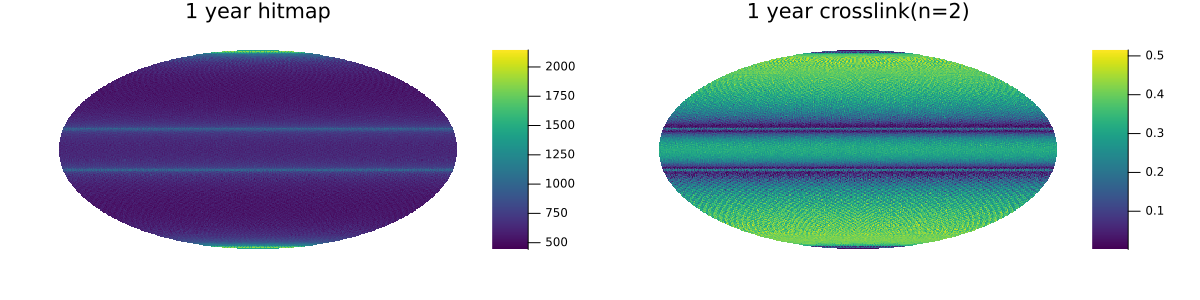

In [13]:
hitmap2 = HealpixMap{Float64, RingOrder}(ss.nside)
hitmap2 .= field2.hitmap
plt_hit = Plots.plot(hitmap2, c=:viridis, title="1 year hitmap")

xlink2 = HealpixMap{Float64, RingOrder}(ss.nside)
xlink2 .= abs.(h_nm(field2, 2,0)); # spin_n=2, spin_m=0のcross-linkの絶対値を計算

plt_xlink = Plots.plot(xlink2, c=:viridis, title="1 year crosslink(n=2)");
Plots.plot(plt_hit, plt_xlink, layout=(1,2), size=(1200,300))

$\phi$方向の線が消え，スピンによる接線のみになったことがわかる．次にヒストグラムを確認してみる．


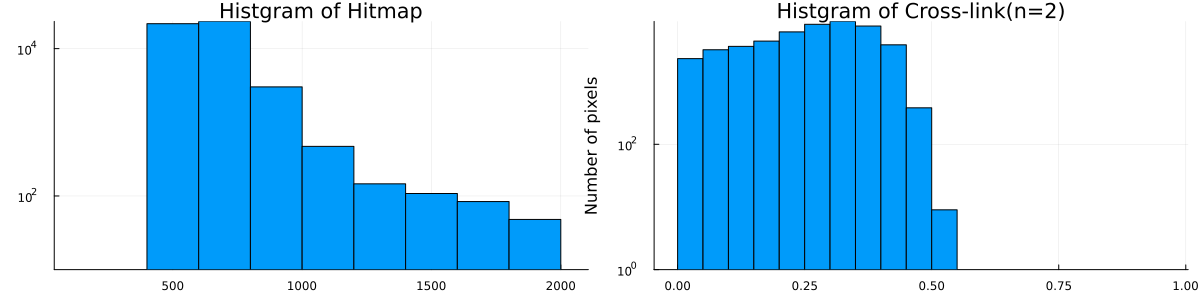

In [14]:
hit_hist = histogram(field2.hitmap, bins=range(0, maximum(field2.hitmap), step=200),
    title="Histgram of Hitmap",
    xlabel="Number of hits",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis=:log10)

xlink_hist = histogram(xlink2.pixels, bins=range(0, 1, step=0.05),
    title="Histgram of Cross-link(n=2)",
    xlabel="Cross-link",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis =:log10)

Plots.plot(hit_hist, xlink_hist, layout=(1,2), size=(1200,300))

### 結果

1. Hitmap のヒストグラムに分裂が消えヒット数の分布がなだらかになっている．
2. クロスリンクの平均値が小さくなり，分散も小さくなっている．

この結果から，初めのパラメータセットよりは偏光観測に対するスキャン戦略由来の系統的効果の低減が期待される．

Python でも同様に Pointing を計算するソフトウェアは存在するが，速度の面では`Falcons.jl`は大きなアドバンテージを持っている．(内部では for ループがスレッド並列化されている．)
実際のスキャン戦略の最適化のためには，スピン軸，歳差軸とそれらの角速度で構成される 4 次元空間の極値探索を行う必要がある．さらに次世代の CMB 偏光観測衛星は十分な統計精度を得るため数千の検出器素子を搭載することが想定される．

多チャンネルの検出器による Pointing を計算し，最適なパラメータセットを決定することは計算オーダー上，非常に困難であるが`Julia`とスーパーコンピュータを利用することで衛星による全天スキャンの新たな展開を得られる可能性がある．最後に，`Falcons`が多チャンネルの検出器によるスキャンにも対応していることを紹介する．


観測開始から 1 秒後のヒットマップをプロットした．空に直径 60deg.の視野が展開されていることがわかる．
各種マップの計算の手続きは単一検出器の時と同じであり，次の通りである．
